# Intro to NN Models in Keras for Stock Market Forecasting

Created by Kenneth Liao

---
This will be a quick introduction to building a simple neural network (NN) model with the Keras API for stock market forecasting. This article is organized into the sections outlined below. 

### The following topics will be covered:

1. Importing and prepping the data
2. Building the NN model
3. Training and evaluating the model's performance

### The data:
We will be using both the **sector_ETFs.csv** and **Indicators_Train.csv** datasets. This data will be split into a training dataset and a cross-validation (cv) dataset. The cv dataset will be used to gauge the model's performance.

---


## 1. Importing and prepping the data

We start by importing the necessary libraries. To make data visualizations a little more legible, let's scale up the default figure and font sizes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
from datetime import datetime
from datetime import timedelta

# Set matplotlib to show plots inline
%matplotlib inline

# Plot settings: Increase figure and font sizes
pylab.rcParams['figure.figsize'] = (10,10)

plt.rc('font', **{'size': 16})

---

After importing the data into a pandas dataframe, we'll want to convert the index to a datetime object. This will allow us to perform special functions on the data such as easily switching between weekly, monthly, or yearly timeframes. Our end goal will be to predict weekly prices so we can go ahead and change the time period of our data to weekly.

---

In [2]:
# Read in data and convert index to datetime object
raw_data = pd.read_csv('sector_ETFs.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.set_index('Date', inplace=True)

# Resample data to a weekly period
weekly_data = raw_data.resample('W').last()
weekly_data = weekly_data.set_index(weekly_data.index.to_period('W'), drop=True)

# Get the number of stocks
N_stocks = len(weekly_data.columns)

print(weekly_data.shape)
weekly_data.head()

(904, 6)


,Technology (IYW),Basic Materials (IYM),Consumer Goods (IYK),Services (IYC),Healthcare (IYH),Utilities (IDU)
Date,,,,,,
2000-05-15/2000-05-21,98.382324,NaN,NaN,NaN,NaN,NaN
2000-05-22/2000-05-28,94.684608,NaN,NaN,NaN,NaN,NaN
2000-05-29/2000-06-04,111.828659,NaN,NaN,NaN,NaN,NaN
2000-06-05/2000-06-11,114.069710,NaN,NaN,NaN,NaN,NaN
2000-06-12/2000-06-18,112.879150,NaN,29.423733,NaN,51.203468,NaN


---

Let's make a quick plot of the 6 ETFs we will be working with.

---

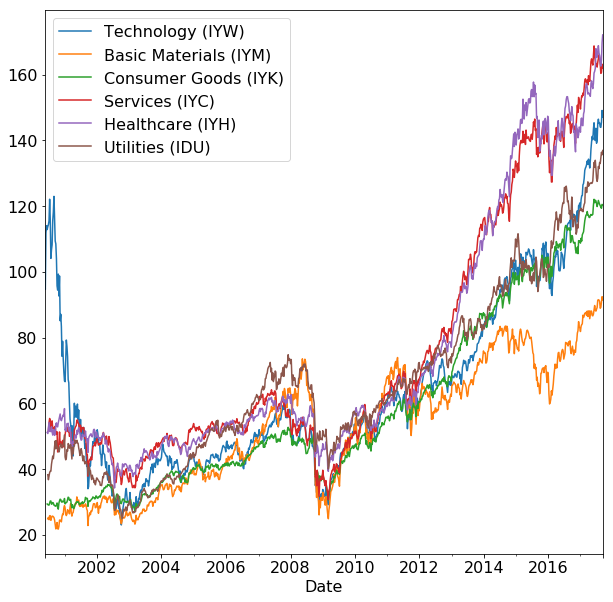

In [3]:
weekly_data.plot()

---

Now we'll import our indicators data and perform the following clean up:
1. Drop nonessential columns (all columns ending with dt)
2. Remove the indicator description row and save it in *indicators_desc*
3. Convert index to a datetime object and resample to a weekly period
3. Drop rows that contain blank dates

---

In [4]:
indicators_train = pd.read_csv('Indicators_Train.csv', skip_blank_lines=True)

# Drop all columns that contain the 'dt' string
for col in indicators_train.columns:
    if 'dt' in col:
        indicators_train.drop(col, axis=1, inplace=True)

# Save the description row and then drop it from the dataframe
indicator_desc = indicators_train.iloc[0,:]
indicators_train.drop(0, inplace=True)
indicators_train.reset_index(inplace=True, drop=True)

# Convert index to datetime object
indicators_train.rename(columns={'date':'Date'}, inplace=True)
indicators_train['Date'] = pd.to_datetime(indicators_train['Date'])
indicators_train = indicators_train.set_index('Date')

# Convert index to weekly time period
indicators_train = indicators_train.resample('W').last()
indicators_train = indicators_train.set_index(indicators_train.index.to_period('W'), drop=True)
indicators_train = indicators_train.apply(pd.to_numeric, errors='coerce', downcast='float')

# Drop rows missing a datetime index value
idx_drop = indicators_train.index[indicators_train.index.isnull()==True]
indicators_train.drop(idx_drop, inplace=True)

N_indicators=len(indicators_train.columns)

---

Let's add the indicator columns to the ETF dataframe. This way, all of the data is in the same place and on the same weekly index.

---

In [5]:
# Add indicators to dataset
combined_data = weekly_data.join(indicators_train, how='left')

# Interpolate any missing values
interp_data = combined_data.interpolate(method='linear')

# Remove any samples that are missing data (blanks)
idx_drop = interp_data.index[interp_data.isnull().any(axis=1)==True]
interp_data.drop(idx_drop, inplace=True)
print(interp_data.shape)
interp_data.head()

(288, 16)


,Technology (IYW),Basic Materials (IYM),Consumer Goods (IYK),Services (IYC),Healthcare (IYH),Utilities (IDU),HOUST,UNRATENSA,EMRATIO,UEMPMED,UMCSENT,USSLIND,KCFSI,IPMAN,VIXCLS,DGS10
Date,,,,,,,,,,,,,,,,
2012-03-05/2012-03-11,69.834488,62.796249,63.997158,74.280342,69.572548,71.152451,699.0,8.7,58.599998,20.299999,75.300003,1.53,-0.11,94.547600,17.110001,2.03
2012-03-12/2012-03-18,71.979347,64.134453,64.649200,75.143074,70.637802,70.857178,699.0,8.7,58.599998,20.299999,75.300003,1.53,-0.11,95.177803,14.470000,2.29
2012-03-19/2012-03-25,72.269714,63.406940,64.878288,75.733902,70.261299,70.578339,698.0,8.7,58.599998,20.299999,75.300003,1.53,-0.11,95.177803,14.820000,2.29
2012-03-26/2012-04-01,72.974030,63.379044,65.580811,76.141914,72.130981,71.319168,698.0,8.7,58.599998,20.299999,76.199997,1.53,-0.11,95.177803,15.480000,2.18
2012-04-02/2012-04-08,72.730186,62.280075,65.563126,75.888046,72.075630,70.996330,698.0,8.4,58.500000,19.900000,76.199997,1.53,-0.11,95.177803,16.700001,2.19


---

The ETF and indicator data we're working with is not a complete set. Each column will have data spanning a different timeframe. More recent dates will have data for all ETFs and indicators while much earlier dates will only have data for some. One way to work with such data is to take a subset of it, only using recent dates to ensure a more complete dataset. We'll start by taking the last year's worth of ETF and indicator data. I encourage you to try longer time spans once you have a working model.

We'll perform an 70/30 split on this subset data for training and cross-validation of the model. 70% of the data will be saved to **train_set** to train the model and 30% will be saved in **cv_set** to gauge the model's performance on data it hasn't yet.

---

In [6]:
# Define the number of years back to use for training
years = 1

# Take a subset of the data (in weeks)
subset_start = years*52

data_subset = interp_data.iloc[-subset_start:, :]

# Separate the data into an 70/30 train/test split
train_start = data_subset.index[0]
train_end = data_subset.index[int(np.floor(0.7*len(data_subset.index)))]
cv_start = train_end + 1
cv_end = data_subset.index[-1]

train_set = data_subset.loc[train_start: train_end, :]
cv_set = data_subset.loc[cv_start:cv_end, :]
print(train_set.shape)
train_set.head()

(37, 16)


,Technology (IYW),Basic Materials (IYM),Consumer Goods (IYK),Services (IYC),Healthcare (IYH),Utilities (IDU),HOUST,UNRATENSA,EMRATIO,UEMPMED,UMCSENT,USSLIND,KCFSI,IPMAN,VIXCLS,DGS10
Date,,,,,,,,,,,,,,,,
2016-09-12/2016-09-18,116.214821,75.145103,109.709953,142.744980,148.202820,118.707428,1211.0,5.0,59.700001,11.2,89.800003,1.53,-0.34,103.669098,15.370000,1.71
2016-09-19/2016-09-25,116.756874,76.267693,111.064880,144.693253,150.265152,122.779961,1142.0,5.0,59.700001,11.2,89.800003,1.53,-0.34,103.669098,12.290000,1.63
2016-09-26/2016-10-02,117.603813,77.424454,110.900330,145.152069,147.982513,118.296898,1142.0,5.0,59.700001,11.2,91.199997,1.53,-0.34,103.669098,13.290000,1.56
2016-10-03/2016-10-09,117.603813,76.101028,109.478783,144.135788,147.499771,113.702843,1142.0,4.8,59.799999,10.3,91.199997,1.53,-0.34,103.669098,13.480000,1.75
2016-10-10/2016-10-16,116.585899,74.718811,108.826424,143.198441,142.524643,115.314629,1142.0,4.8,59.799999,10.3,91.199997,1.53,-0.39,103.669098,16.120001,1.75


In [7]:
print(cv_set.shape)
cv_set.head()

(15, 16)


,Technology (IYW),Basic Materials (IYM),Consumer Goods (IYK),Services (IYC),Healthcare (IYH),Utilities (IDU),HOUST,UNRATENSA,EMRATIO,UEMPMED,UMCSENT,USSLIND,KCFSI,IPMAN,VIXCLS,DGS10
Date,,,,,,,,,,,,,,,,
2017-05-29/2017-06-04,145.351501,88.532379,122.084198,168.729996,160.479645,133.269867,1172.0,4.1,60.0,10.4,97.099998,1.64,-0.56,104.617599,9.75,2.21
2017-06-05/2017-06-11,141.645691,89.776260,121.067482,165.455994,161.005127,131.856369,1172.0,4.1,60.0,10.4,97.099998,1.64,-0.74,104.617599,10.70,2.19
2017-06-12/2017-06-18,139.926880,88.404045,121.807808,164.215866,161.877640,133.947144,1092.0,4.1,60.0,10.4,97.099998,1.64,-0.74,104.170197,10.38,2.16
2017-06-19/2017-06-25,143.672455,88.078262,121.610390,163.174118,167.885971,131.503006,1092.0,4.1,60.0,10.4,97.099998,1.64,-0.74,104.170197,10.02,2.15
2017-06-26/2017-07-02,139.132919,88.624802,120.668373,163.276489,165.287003,128.554337,1092.0,4.1,60.0,10.4,95.099998,1.64,-0.74,104.170197,11.18,2.27


---

Before the data can be fed into the model, it will have to be normalized. We will scale the data so that the minimum and maximum for each column correspond to 0 and 1. It's important to note that normalization must be done after splitting the data into the train and cv sets. Otherwise, the NN model would see information from the cv dataset.

The plot belows shows the 6 normalized ETFs from the training dataset. This is the output that the model will be trying to fit.

---

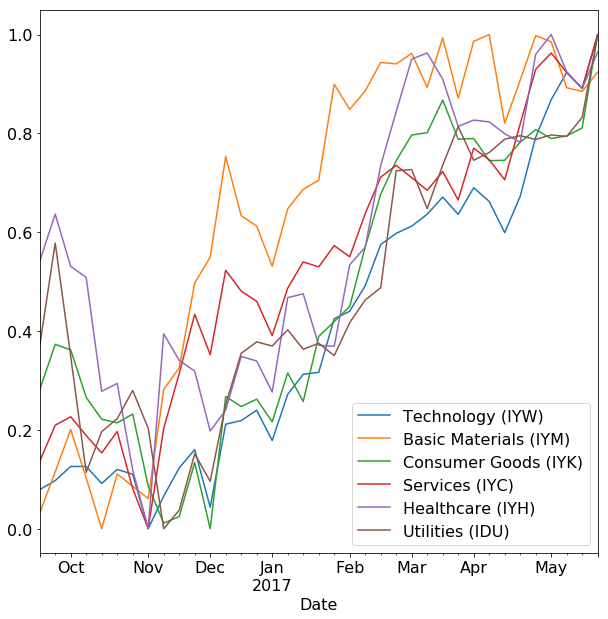

In [8]:
# Normalize the two datasets, plot the normalized train data
train_norm = ((train_set - train_set.min())/(train_set.max() - train_set.min())) 
cv_norm = ((cv_set - cv_set.min())/(cv_set.max() - cv_set.min())) 

for col in train_set:
    if train_set[col].nunique() == 1:
        train_norm[col] = train_set[col]
for col in cv_set:
    if cv_set[col].nunique() == 1:
        cv_norm[col] = cv_set[col]
        
train_norm.iloc[:,:N_stocks].plot()

---

The last step in the data prep is to split the train and cv datasets into inputs (X) and outputs (Y) for the model. We will go into more detail on what these matrices are.

---

In [9]:
# Dimensions: [# training samples x # indicators]
X_train = train_norm.iloc[:, N_stocks:] 
X_cv = cv_norm.iloc[:, N_stocks:] 

# Dimensions: [# training samples x # ETFs]
Y_train = train_norm.iloc[:, :N_stocks]
Y_cv = cv_norm.iloc[:, :N_stocks]

In [10]:
X_train.head()

,HOUST,UNRATENSA,EMRATIO,UEMPMED,UMCSENT,USSLIND,KCFSI,IPMAN,VIXCLS,DGS10
Date,,,,,,,,,,
2016-09-12/2016-09-18,0.594203,0.9,0.000000,1.00,0.230089,1.0,0.903226,0.0,0.453138,0.144231
2016-09-19/2016-09-25,0.344203,0.9,0.000000,1.00,0.230089,1.0,0.903226,0.0,0.202119,0.067308
2016-09-26/2016-10-02,0.344203,0.9,0.000000,1.00,0.353982,1.0,0.903226,0.0,0.283619,0.000000
2016-10-03/2016-10-09,0.344203,0.7,0.199997,0.25,0.353982,1.0,0.903226,0.0,0.299103,0.182692
2016-10-10/2016-10-16,0.344203,0.7,0.199997,0.25,0.353982,1.0,0.741936,0.0,0.514262,0.182692


In [11]:
Y_train.head()

,Technology (IYW),Basic Materials (IYM),Consumer Goods (IYK),Services (IYC),Healthcare (IYH),Utilities (IDU)
Date,,,,,,
2016-09-12/2016-09-18,0.078983,0.031652,0.281273,0.136381,0.541015,0.369868
2016-09-19/2016-09-25,0.097304,0.115004,0.372994,0.209351,0.636559,0.578091
2016-09-26/2016-10-02,0.125931,0.200894,0.361855,0.226536,0.530809,0.348878
2016-10-03/2016-10-09,0.125931,0.102629,0.265624,0.188472,0.508444,0.113989
2016-10-10/2016-10-16,0.091525,0.000000,0.221463,0.153365,0.277955,0.196398


---


## II. Building the NN Model

When building any machine learning model, it's important to understand the inputs and outputs for the model. Let's remind ourselves what we're trying to do with our NN model.

What question are we trying to answer?

*Given some macroeconomic data over some time period, can our NN model predict ETF prices over the same time period?*

So we need our NN model to:

*Take in macroeconomic data and output ETF prices*

---

Let's call out what X and Y are explicitly. X is what we feed the NN model and Y is what it tries to predict. In our case, X is the indicator data over the specified timeframe. Given X, the NN will output its predictions of the ETF prices. We can then compare the model's predictions to the actual ETF prices (Y) over the same timeframe. 

Below we can see the shapes of our X and Y matrices for both the training and cv data. The first dimension in each matrix is the number of samples. For us, each sample corresponds to a particular weekly time period. In the training set we have 37 samples and in our cv set we have 15: recall our 70/30 split on one year's worth of data. For the X_train and X_cv matrices, the second dimension is the number of indicators which is 10. For the Y_train and Y_cv matrices, the second dimension corresponds to the number of ETFs which is 6. Scroll up to see X_train and Y_train for a reminder of what these matrices look like. These matrix shapes are important when setting up your NN model.

---

In [12]:
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("\n" + "X_cv shape: " + str(X_cv.shape))
print("Y_cv shape: " + str(Y_cv.shape))

X_train shape: (37, 10)
Y_train shape: (37, 6)

X_cv shape: (15, 10)
Y_cv shape: (15, 6)


---

We will be utilizing the **sequential** model for our NN. The sequential model allows us to simply add layers to our network, one by one, to form a linear stack. 

We then add the first hidden layer with **model.add()**. We feed this the **Dense()** function which means every node in the hidden layer will be connected to every node from the previous layer (input layer). 

The first argument given to *Dense()* is the # of output units which is equal to the number of nodes in the hidden layer. We will start with 10, the same as the input layer. 

The *input_shape()* argument corresponds to the shape of the input you're feeding the model. To train our model we want to feed it X_train, which has a shape of (37,10), and have it predict Y_train of shape (37,6). So our input_shape() should be (37,10). Keras allows us to simply specify the dimension of a single sample and leave the second dimension open for flexibility. That way we can feed it different batch sizes of samples with the same sample dimension. So we can simply pass input_shape(10,), leaving the batch size open. 

The last argument is the activation function we want to apply to the layer's output. We will start with the rectified linear (relU) function. Other functions you can try are the 'sigmoid' and 'tanh' functions.

Then we add the output layer which will have a dimension of 6, for our 6 ETFs. For all layers after the initial hidden layer, we need not specify the input_shape as it is inferred from the previous layer.

Once the model architecture is specified, we have to compile the model. We can pass 'mse' (mean squared error) to the *loss* argument which is what the model tries to minimize. We will use the 'adam' optimizer which is a form of stochastic gradient descent, and specify 'mse' as our metric which the model will calculate for us at every iteration during training.

We now have a Keras NN model!

---

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense

# Define NN model architecture: we will use the seqential model.
model = Sequential()

# Add the first hidden layer
model.add(Dense(10, input_shape=(10,), activation='relu'))

# Add the output layer
model.add(Dense(6))

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Print the model summary
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 66        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


## 3. Training & Evaluating The Model

---

To train the model we use the model.fit() method. We have to specify the training data by passing it X_train and Y_train. We can also pass in our validation data, X_cv and Y_cv. Finally, we have to specify how many iterations or epochcs we want the model to train for.

Details about each training iteration are printed as the model trains. We can get the results of training from H.history(), which stores the loss and metric values. We'll store the MSE values in **mse_train** and **mse_cv**.

---

In [14]:
# THIS WILL THROW AN ERROR IF ANY DATA IS MISSING IN THE TRAINING SET

# Fit the model
H = model.fit(X_train, Y_train, 
              validation_data=(X_cv, Y_cv), epochs=100)

# Save the mean squared errors
mse_train = np.array(H.history['mean_squared_error'])
mse_cv = np.array(H.history['val_mean_squared_error'])

Train on 37 samples, validate on 15 samples
Epoch 1/100
37/37 [==============================] - 0s 3ms/step - loss: 0.3886 - mean_squared_error: 0.3886 - val_loss: 0.3580 - val_mean_squared_error: 0.3580
Epoch 2/100
37/37 [==============================] - 0s 90us/step - loss: 0.3814 - mean_squared_error: 0.3814 - val_loss: 0.3508 - val_mean_squared_error: 0.3508
Epoch 3/100
37/37 [==============================] - 0s 90us/step - loss: 0.3749 - mean_squared_error: 0.3749 - val_loss: 0.3440 - val_mean_squared_error: 0.3440
Epoch 4/100
37/37 [==============================] - 0s 82us/step - loss: 0.3688 - mean_squared_error: 0.3688 - val_loss: 0.3375 - val_mean_squared_error: 0.3375
Epoch 5/100
37/37 [==============================] - 0s 95us/step - loss: 0.3628 - mean_squared_error: 0.3628 - val_loss: 0.3313 - val_mean_squared_error: 0.3313
Epoch 6/100
37/37 [==============================] - 0s 92us/step - loss: 0.3570 - mean_squared_error: 0.3570 - val_loss: 0.3254 - val_mean_squared

---

Below is a plot of the Training MSE and Validation MSE. The training MSE is the MSE calculated between the predictions of the model and Y_train, given X_train as the input. The Validation MSE is the MSE calculated between the predictions of the model and Y_cv, given X_cv as the input.

The downtrend in both curves suggests the model is making better predictions with each iteration!

---

cv MSE minimum: 0.129383
train MSE minimum: 0.056376


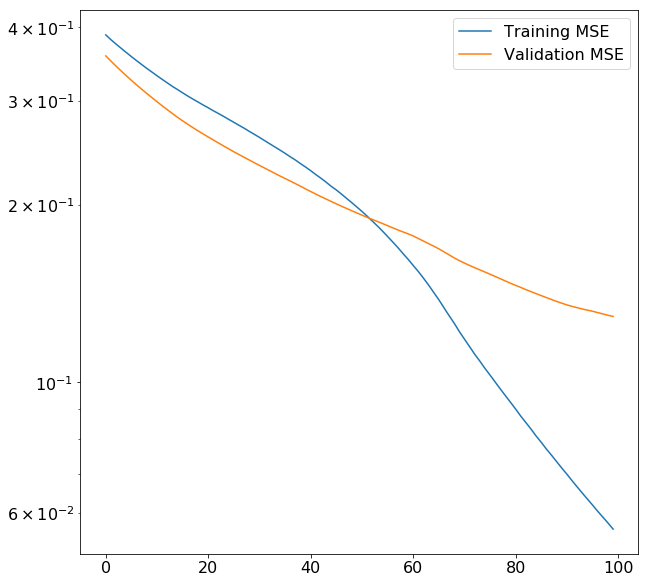

In [15]:
# Plot the MSE vs iteration
plt.plot(H.history['mean_squared_error'])
plt.plot(H.history['val_mean_squared_error'])
plt.yscale('log')
plt.legend(['Training MSE', 'Validation MSE'])

print('cv MSE minimum: %f' % mse_cv.min())
print('train MSE minimum: %f' % mse_train.min())

---

The plots below show the actual ETF prices in blue and the model's predictions in orange. The black, dashed, vertical line delineates the training data to the left, and the cross-validation data to the right. So to the left of the line we can see how well the predictions fit the training data, and to the right we can see how well the model predicts prices based on indicator data it hasn't seen before.

We can see there is some overlay of the model's predictions with the actual data, but it's not great. The relative "flatness" of the predicted data and generally poor fit of the training data suggests the model is underfitting the data.

This simple model can make much better predictions given the right tuning! Play around with the model to see how you can get better predictions. Remember that the goal is for the model to make accurate predictions on the cv data, not necessarily to make the best predictions on the training data.

Things to try:
1. Add more nodes to the hidden layer (20, 50, 100, etc.)
2. Add more hidden layers
3. Use different activation functions
4. Use more training data by changing years>1
5. Change the number of epochs for training

For a pretty good model try a single hidden layer with 50 units, 'tanh' activator, and 5 years of training data.

Hint: Change the parameters and then go to *Kernel* and hit *Restart & Run All*

---

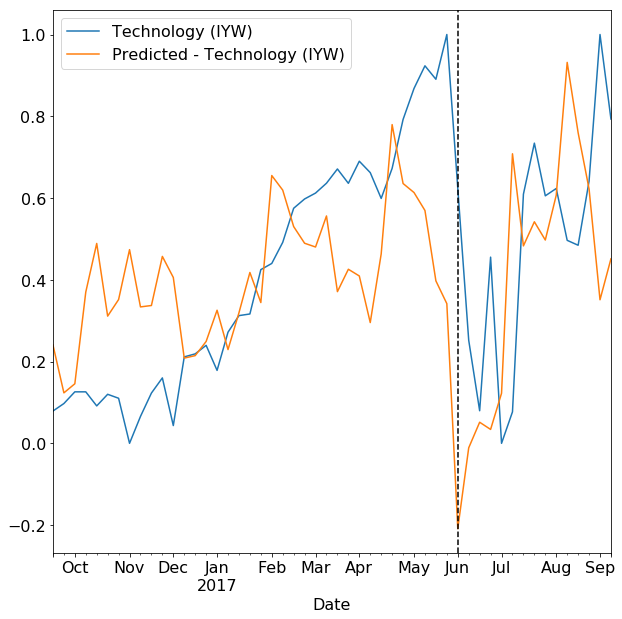

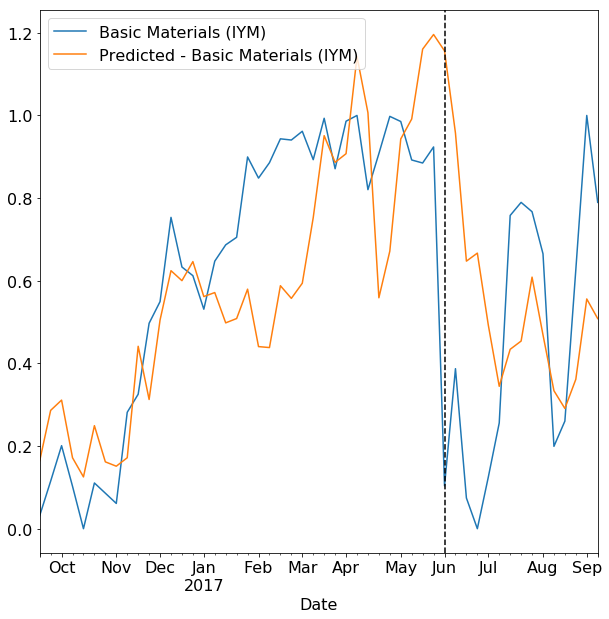

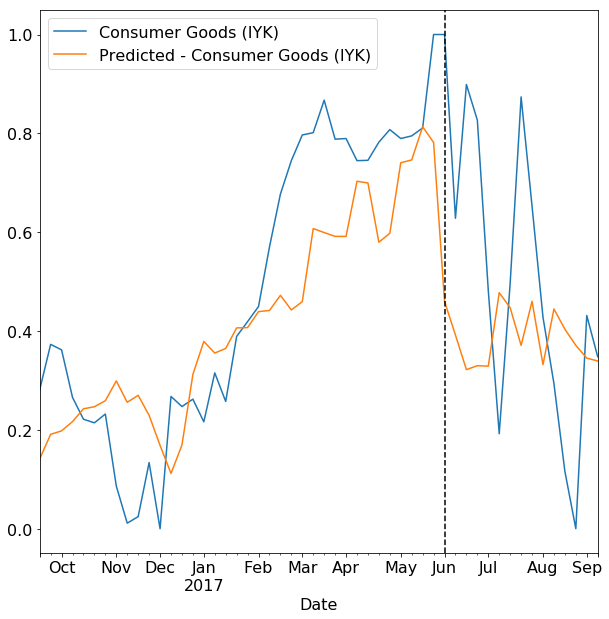

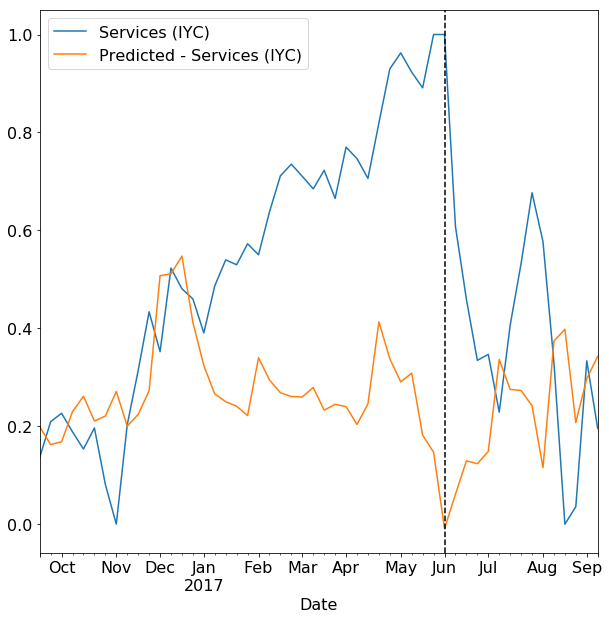

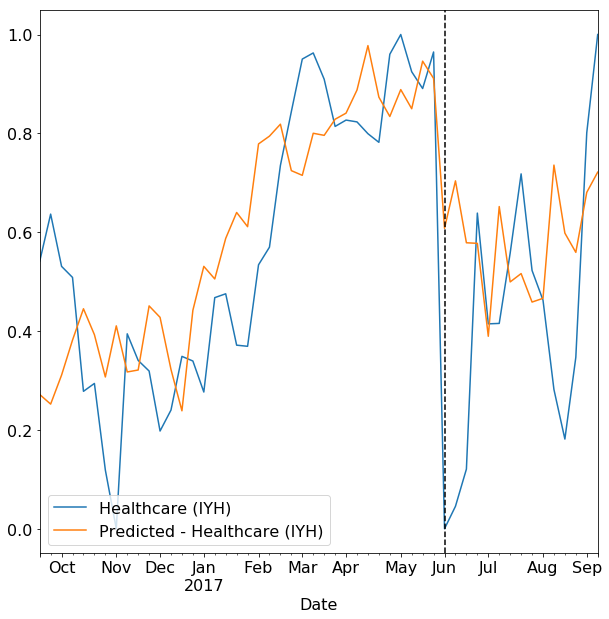

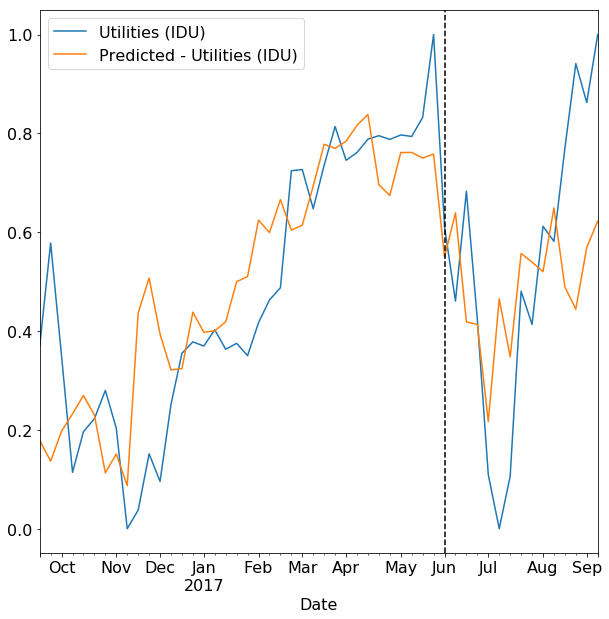

In [16]:
# Get the *trained* model's predictions on X_train and X_cv
predictions_train = model.predict(X_train)
predictions_cv = model.predict(X_cv)

# Rename predicted columns
predicted_col_names = []
for col in Y_train.columns:
    predicted_col_names.append('Predicted - ' + col)

# Merge Y_train and the model predictions into a single dataframe
plot_data_train = pd.DataFrame(Y_train).join(
    pd.DataFrame(predictions_train, index=Y_train.index,
                columns=predicted_col_names), how='left')

# Merge Y_cv and the model predictions
plot_data_cv = pd.DataFrame(Y_cv).join(
    pd.DataFrame(predictions_cv, index=Y_cv.index,
                columns=predicted_col_names), how='left')

# Stack the two dataframes above 
plot_all = pd.concat([plot_data_train, plot_data_cv])

# Plot each of the ETFs and their predicted values
delineator = plot_data_cv.index[0]
stocks = np.arange(N_stocks)

for stock in stocks:
    plot_all.iloc[:, [stock,stock+len(Y_train.columns)]].plot()
    plt.axvline(x=delineator, label='prediction', 
                linestyle='--', color='black')